*This is a notebook for kaggle competition - CareerCon 2019 - Help Navigate Robots.
*The approach is to convert the time series data into spectrums by FFT.
*The key focus is generating and selecting features from these spectrums.
*After optimizing, re-run with test dataset for submission.
*With a simple random forest classifier, the result is ranked in the top 5% in the competition. 

## Import liberies and upload data

In [8]:
"""import liberies"""
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
#from imblearn.over_sampling import SMOTE
import statistics
import matplotlib.pyplot as plt  

In [3]:
"""Loading data"""
train = pd.read_csv('C:/Users/yongc/Documents/Career/Kaggle/CareerCon 2019 - Help Navigate Robots/X_train.csv')
y = pd.read_csv('C:/Users/yongc/Documents/Career/Kaggle/CareerCon 2019 - Help Navigate Robots/y_train.csv')
test = pd.read_csv('C:/Users/yongc/Documents/Career/Kaggle/CareerCon 2019 - Help Navigate Robots/X_test.csv')
sub = pd.read_csv('C:/Users/yongc/Documents/Career/Kaggle/CareerCon 2019 - Help Navigate Robots/sample_submission.csv')

In [4]:
train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [5]:
y['surface'].value_counts()

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64

Notice that the sample size is unbalanced.

## Feature Engineering

Data from the sensors are time series of orientation, speed etc. of the robot. Based on the understanding that the robot will vibrate in different mode on different surfaces, it is better to analyze these data in frequency domain. FFT is applied on the dataset first and then take the absolute value of the FFT. 

Here a toolbox is mode to experiment various features on the FFT sets.
1. Area under the curve 
2. Smoothing with moving average
3. Find the peak near a point
4. Substrate background from the peak
5. Calculate the total intensity of a peak
6. The intensity ratios between two peaks
7. Spectrum stability (FFT on different sections of the time series)
8. The toolbox are applied manually in experiment, optimized based on model performance.
9. Remove features which are not significant based on 'classifier.feature_importances_'. 

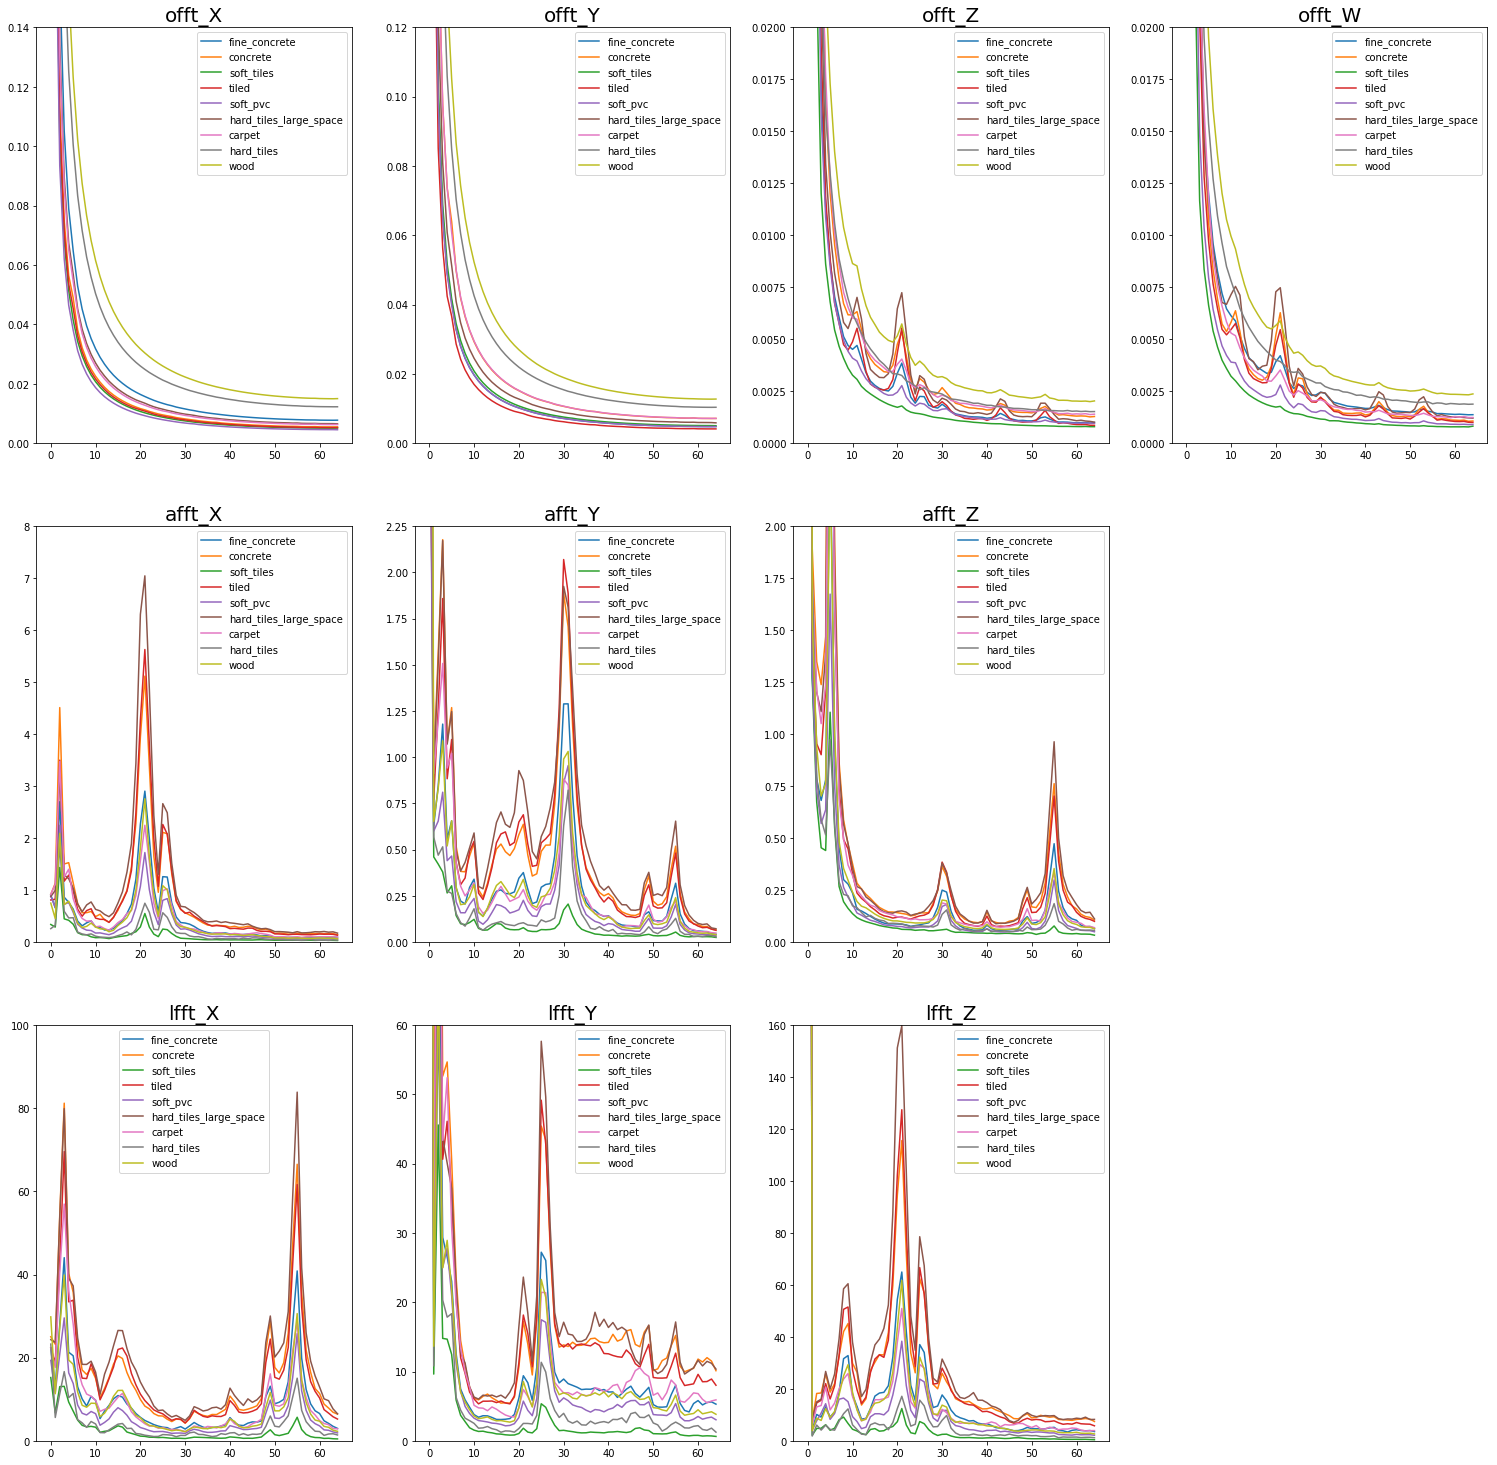

In [9]:
"""First, take a look on the average spectra"""

# Get a list of unique surface types
surfaces_list=y['surface'].unique()

seriesID_list=train['series_id'].unique()

# Define a list of column names to store fft data
fft_names_list=['offt_X','offt_Y','offt_Z','offt_W','afft_X','afft_Y','afft_Z','lfft_X','lfft_Y','lfft_Z']
# Prefix offt, afft, and lfft are assgined as the names for fft data of orientation, angular_velocity, and linear_acceleration, respectively

# Calculate FFT data for each series (Each series consists of 128 units of time)
# Each series has 10 parameters (orientation_X,...,angular_velocity_X,....,linear_acceleration_X,...)
# Each of the parameters will be fourier transformed using numpy fft function
fft_data={}
for seriesID in seriesID_list:
    fft_data[seriesID]={}
    i=-1
    for col in train.columns[3:]:   #stepping through each columns
        c=np.fft.rfft(train[train['series_id']==seriesID][col])  # Calculate real fft
        x=np.real(np.abs(c))  # Calculate the amplitude of fft
        i+=1
        fft_name=fft_names_list[i]  # Assign names for fft data (orientation_X-->offt_X, etc.)
        fft_data[seriesID][fft_name]=x
        
# Group series_id's into their respective surface types
seriesID_group={}
for floor_type in surfaces_list:
    seriesID_group[floor_type]=y[y['surface']==floor_type].series_id
    
#Calculate fft average for each parameter_X,Y,Z for each surface.  
#These average values are for viewing only, not used for training.
fft_average={}
for floor_type in surfaces_list:
    count=len(seriesID_group[floor_type])
    fft_average[floor_type]={}
    cumsum={}
    for fft in fft_names_list:
        cumsum[fft]=np.zeros(65)
        for seriesID in seriesID_group[floor_type]:
            cumsum[fft]+=fft_data[seriesID][fft]
        fft_average[floor_type][fft]=np.zeros(65)
        fft_average[floor_type][fft]=cumsum[fft]/count  
        
# Preview of fft spectra
plt.figure(figsize=(26, 26))
i=0
ylim={}
ylim['offt_X']=[0,0.14]
ylim['offt_Y']=[0,0.12]
ylim['offt_Z']=[0,0.02]
ylim['offt_W']=[0,0.02]
ylim['afft_X']=[0,8]
ylim['afft_Y']=[0,2.25]
ylim['afft_Z']=[0,2]
ylim['lfft_X']=[0,100]
ylim['lfft_Y']=[0,60]
ylim['lfft_Z']=[0,160]
for fft in fft_names_list:
    i+=1
    if i==8:
        i+=1
    plt.subplot(3,4,i)
    plt.ylim(ylim[fft][0],ylim[fft][1])
    plt.title(fft, fontsize=20)
#    plt.yscale('log')
    for floor_type in surfaces_list:
        plt.plot(fft_average[floor_type][fft][:])
    plt.legend(surfaces_list)

Thank Tue Ngo for above cell for platting.

In [ ]:
"""Covert data to FFT"""
def fft_features(data, p1=0, p2=0, p3=0, p4=0, p5=0, p6=0, hw1=0, hw2=0, hw3=0, hw4=0, hw5=0, hw6=0):
#    pi is location of peak i; hw is half width of peak i.
    fftl = np.fft.rfft(data)                                  #FFT
    abs_fft = np.abs(fftl[0:63])                              #take the absolute value
    auc_fft = sum(abs_fft[8:63])                              #Area under the curve
#    ma = [sum(abs_fft[k-1:k+2])/3 for k in range(1,62)]      #moving average
#    abs_fft = abs_fft.rolling(window=3).mean()               #smoothing
#    peak1 = max(ma[p1-hw1-1:p1+hw1])                         
#    peak2 = max(ma[p2-hw2-1:p2+hw2])
#    peak3 = max(ma[p3-hw3-1:p3+hw3])
#    peak4 = max(ma[p4-hw4-1:p4+hw4])
#    peak5 = max(ma[p5-hw5-1:p5+hw5])
#    peak6 = max(ma[p6-hw6-1:p6+hw6])    

    peak1 = max(abs_fft[p1-hw1:p1+hw1+1])                     #Find the peak near a point p1
    peak2 = max(abs_fft[p2-hw2:p2+hw2+1])
    peak3 = max(abs_fft[p3-hw3:p3+hw3+1])
    peak4 = max(abs_fft[p4-hw4:p4+hw4+1])
    peak5 = max(abs_fft[p5-hw5:p5+hw5+1])
    peak6 = max(abs_fft[p6-hw6:p6+hw6+1])    

    return [auc_fft, peak1, peak2, peak3, peak4, peak5, peak6]

In [ ]:
"""Spectrum stability"""
def fft_stability (data, fft_len=64, step_size=8):
    """cut the data can fft on various settion of the data, calculate Average, Stdev, Range"""
    fft_time_serises = []
    n = int((128 - fft_len) // step_size) + 1
    for i in range(n):
        data_section = data[i*step_size:fft_len+i*step_size]
        fftl = np.fft.rfft(data_section)
        abs_fft = np.abs(fftl[0:int(fft_len/2)])
        auc_fft = max(abs_fft[1:int(fft_len/2)])
        fft_time_serises.append(auc_fft)
        
    Average = sum(fft_time_serises)/n
    Median = statistics.median(fft_time_serises)
    Sigma = statistics.stdev(fft_time_serises)
    Range = (max(fft_time_serises) - min(fft_time_serises))
    
    return [Average, Median, Sigma, Range]

In [ ]:
# here is one example of feature building. the above toolbox is applied to each sensors.
# First we generate and scan trought many features
# We will remove insignficant features iteratively

"""
train_fft_df = train[['series_id']].drop_duplicates().reset_index(drop=True)
for col in train.columns[3:]:
    for i in range(len(train_fft_df)):
        a = train.loc[train['series_id'] == i , col]
        data = a - a.mean()
        fft_data = fft_features(data, p1=2, p2=5, p3=21, p4=26, p5=31, p6=55, hw1=2, hw2=2, hw3=2, hw4=2, hw5=2, hw6=2)
#        train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
        if col == train.columns[4]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0] 
        elif col == train.columns[6]:
#            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0] 
            train_fft_df.loc[i, col+"_peak21"] = fft_data[3]
        elif col == train.columns[7]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[1]
#            train_fft_df.loc[i, col+"_peak21"] = fft_data[3]
            train_fft_df.loc[i, col+"_peak2/peak21"] = fft_data[1] / fft_data[3]
#            train_fft_df.loc[i, col+"_auc_fft/peak21"] = fft_data[0] / fft_data[3]                                
        elif col == train.columns[8]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
            train_fft_df.loc[i, col+"_peak31"] = fft_data[5]            
#            train_fft_df.loc[i, col+"_peak4"] = fft_data[4]           
            train_fft_df.loc[i, col+"_peak2/peak31"] = fft_data[1] / fft_data[5]
            train_fft_df.loc[i, col+"_peak21/peak31"] = fft_data[3] / fft_data[5]
#            train_fft_df.loc[i, col+"_auc_fft/peak31"] = fft_data[0] / fft_data[5]                     
        elif col == train.columns[9]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
            train_fft_df.loc[i, col+"_peak5"] = fft_data[2]            
#            train_fft_df.loc[i, col+"_peak5/peak55"] = fft_data[2] / fft_data[6]
#            train_fft_df.loc[i, col+"_auc_fft/peak5"] = fft_data[0] / fft_data[2]
        elif col == train.columns[10]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[1]            
            train_fft_df.loc[i, col+"_peak55"] = fft_data[6]            
            train_fft_df.loc[i, col+"_peak2/peak55"] = fft_data[1] / fft_data[6]
#            train_fft_df.loc[i, col+"_auc_fft/peak55"] = fft_data[0] / fft_data[6]
        elif col == train.columns[11]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[1]
            train_fft_df.loc[i, col+"_peak26"] = fft_data[4]            
#            train_fft_df.loc[i, col+"_peak2/peak25"] = fft_data[1] / fft_data[4] 
#            train_fft_df.loc[i, col+"_auc_fft/peak25"] = fft_data[0] / fft_data[4]            
        elif col == train.columns[12]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
#            train_fft_df.loc[i, col+"_peak21"] = fft_data[3]
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[2]            
#            train_fft_df.loc[i, col+"_peak25"] = fft_data[4]            
#            train_fft_df.loc[i, col+"_peak5"] = fft_data[5]
#            train_fft_df.loc[i, col+"_peak21/peak25"] = fft_data[3] / fft_data[4] 
#            train_fft_df.loc[i, col+"_auc_fft/peak21"] = fft_data[0] / fft_data[3]            
"""

In [ ]:
'''Here is just another example, including features measuring spectrum stability.'''

train_fft_df = train[['series_id']].drop_duplicates().reset_index(drop=True)
for col in train.columns[3:]:
#    if col != train.columns[9]:
    for i in range(len(train_fft_df)):
        a = train.loc[train['series_id'] == i , col]
        data = a - a.mean()
        fft_data = fft_stability (data, fft_len=16, step_size=4)
        train_fft_df.loc[i, col+"_Average+Median"] = fft_data[0] + fft_data[1]
#            train_fft_df.loc[i, col+"_Average-Median"] = fft_data[0] - fft_data[1]            
        train_fft_df.loc[i, col+"_Sigma+Range"] = fft_data[2] + fft_data[3]  
#            train_fft_df.loc[i, col+"_Range/Sigma"] = fft_data[3] / fft_data[2]
#            train_fft_df.loc[i, col+"_Range"] = fft_data[2]    
"""        
        if col == train.columns[4]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0] 
        elif col == train.columns[6]:
#            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0] 
            train_fft_df.loc[i, col+"_peak21"] = fft_data[3]
        elif col == train.columns[7]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[1]
#            train_fft_df.loc[i, col+"_peak21"] = fft_data[3]
            train_fft_df.loc[i, col+"_peak2/peak21"] = fft_data[1] / fft_data[3]
#            train_fft_df.loc[i, col+"_auc_fft/peak21"] = fft_data[0] / fft_data[3]                                
        elif col == train.columns[8]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
            train_fft_df.loc[i, col+"_peak31"] = fft_data[5]            
#            train_fft_df.loc[i, col+"_peak4"] = fft_data[4]           
            train_fft_df.loc[i, col+"_peak2/peak31"] = fft_data[1] / fft_data[5]
            train_fft_df.loc[i, col+"_peak21/peak31"] = fft_data[3] / fft_data[5]
#            train_fft_df.loc[i, col+"_auc_fft/peak31"] = fft_data[0] / fft_data[5]                     
        elif col == train.columns[9]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
            train_fft_df.loc[i, col+"_peak5"] = fft_data[2]            
#            train_fft_df.loc[i, col+"_peak5/peak55"] = fft_data[2] / fft_data[6]
#            train_fft_df.loc[i, col+"_auc_fft/peak5"] = fft_data[0] / fft_data[2]
        elif col == train.columns[10]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[1]            
            train_fft_df.loc[i, col+"_peak55"] = fft_data[6]            
            train_fft_df.loc[i, col+"_peak2/peak55"] = fft_data[1] / fft_data[6]
#            train_fft_df.loc[i, col+"_auc_fft/peak55"] = fft_data[0] / fft_data[6]
        elif col == train.columns[11]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[1]
            train_fft_df.loc[i, col+"_peak26"] = fft_data[4]            
#            train_fft_df.loc[i, col+"_peak2/peak25"] = fft_data[1] / fft_data[4] 
#            train_fft_df.loc[i, col+"_auc_fft/peak25"] = fft_data[0] / fft_data[4]            
        elif col == train.columns[12]:
            train_fft_df.loc[i, col+"_auc_fft"] = fft_data[0]    
#            train_fft_df.loc[i, col+"_peak21"] = fft_data[3]
#            train_fft_df.loc[i, col+"_peak2"] = fft_data[2]            
#            train_fft_df.loc[i, col+"_peak25"] = fft_data[4]            
#            train_fft_df.loc[i, col+"_peak5"] = fft_data[5]
#            train_fft_df.loc[i, col+"_peak21/peak25"] = fft_data[3] / fft_data[4] 
#            train_fft_df.loc[i, col+"_auc_fft/peak21"] = fft_data[0] / fft_data[3]            
"""

## Model - Random Forest Classification

In [ ]:
"""Creating the Training and Test set from data"""

"""Creating the dependent variable class"""
factor = pd.factorize(y['surface'])
y.surface = factor[0]
definitions = factor[1]
print(y.surface.head())
print(definitions)

X = train_fft_df.iloc[:, 1:36].values  
y = y.iloc[:, 2].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#smote = SMOTE('minority')
#X_train, y_train = smote.fit_sample(X_train, y_train)

"""Feature Scaling"""
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
"""Fitting Random Forest Classification to the Training set"""
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 41, class_weight='balanced')
#classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 41, class_weight={0:2, 1:0.9, 2:1, 3:1, 4:1, 5:1, 6:5, 7:20, 8:1})
#classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 41)
classifier.fit(X_train, y_train)

In [ ]:
"""Sorting features of the trained model"""
print(list(zip(train_fft_df.columns[1:36], classifier.feature_importances_)))
feature_ranking = list(zip(train_fft_df.columns[1:36], classifier.feature_importances_))
joblib.dump(classifier, 'randomforestmodel.pkl')

#Feature which are not significant are removed, and re-run the model again. Iterating until it is optimized. 

## Model Evaluation

In [ ]:
"""Predicting the Test set results"""
y_pred = classifier.predict(X_test)
"""Reverse factorize (converting y_pred from 0s,1s, ..., 8s to 'fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood')"""
reversefactor = dict(zip(range(9),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Surface'], colnames=['Predicted Surface']))
cm = pd.crosstab(y_test, y_pred, rownames=['Actual Surface'], colnames=['Predicted Surface'])